In [30]:
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [31]:
# Fetch data
ticker = '^NSEI'
df = yf.download(ticker, start='2023-10-01', end='2024-10-01')
df = df.asfreq('B')  # Set frequency to business days ('B')
data = df['Close']

[*********************100%***********************]  1 of 1 completed


In [32]:
data.dropna(inplace=True)
data

Ticker,^NSEI
Date,
2023-10-03 00:00:00+00:00,19528
2023-10-04 00:00:00+00:00,19436
2023-10-05 00:00:00+00:00,19545
2023-10-06 00:00:00+00:00,19653
2023-10-09 00:00:00+00:00,19512
...,...
2024-09-24 00:00:00+00:00,25940
2024-09-25 00:00:00+00:00,26004
2024-09-26 00:00:00+00:00,26216


In [33]:
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("Data is non-stationary. Consider differencing.")
    else:
        print("Data is stationary.")
        
        
print("Initial stationarity check:")
check_stationarity(data)

Initial stationarity check:
ADF Statistic: -0.3696775000912647
p-value: 0.9150397764779998
Data is non-stationary. Consider differencing.


In [34]:
diff_data = data.diff().dropna()
diff_data.head()

print("\nStationarity check after differencing:")
check_stationarity(diff_data)


Stationarity check after differencing:
ADF Statistic: -18.691907593462908
p-value: 2.0391149762808425e-30
Data is stationary.


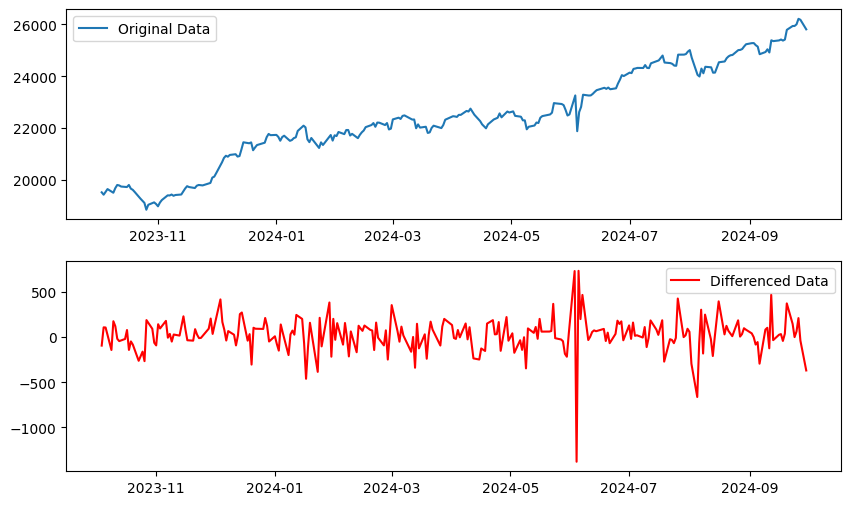

In [79]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(data, label='Original Data')
plt.legend()
plt.subplot(2,1,2)
plt.plot(diff_data, label='Differenced Data', color='red')
plt.legend()
plt.show()

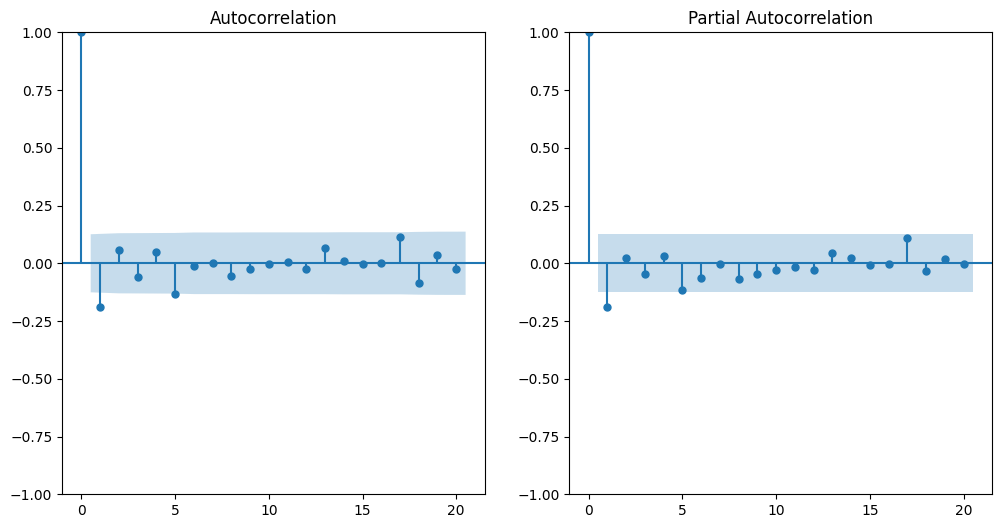

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(diff_data, lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(diff_data, lags=20, ax=plt.gca())
plt.show()

APPROACH 1

In [37]:
# Split data into training and validation sets
train_size = int(len(data) * 0.8)
train, validation = data[:train_size], data[train_size:]

In [38]:
p_range = range(0, 8)
d_range = range(1, 2)
q_range = range(0, 8)

In [39]:
best_rmse = float("inf")
best_order = None
best_model = None

In [40]:
from sklearn.metrics import mean_squared_error
from itertools import product
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

for p, d, q in product(p_range, d_range, q_range):
    try:
        # Fit the ARIMA model
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        
        # Forecast on validation set
        forecast = model_fit.forecast(steps=len(validation))
        
        # Calculate RMSE for the forecast
        rmse = np.sqrt(mean_squared_error(validation, forecast))
        print(f'Order: {(p, d, q)}, RMSE: {rmse}')
        
        # Update best model if RMSE is lower
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = (p, d, q)
            best_model = model_fit

    except Exception as e:
        print(f'Failed to fit ARIMA({p}, {d}, {q}): {e}')
        
print(f'Best (p, d, q) order: {best_order}, RMSE: {best_rmse}')

Order: (0, 1, 0), RMSE: 738.429892737712
Order: (0, 1, 1), RMSE: 730.3201877570243
Order: (0, 1, 2), RMSE: 749.7964976497336
Order: (0, 1, 3), RMSE: 748.1141969106758
Order: (0, 1, 4), RMSE: 754.8500343570333
Order: (0, 1, 5), RMSE: 754.3740700892988
Order: (0, 1, 6), RMSE: 753.4462830677647
Order: (0, 1, 7), RMSE: 753.5820629320685
Order: (1, 1, 0), RMSE: 735.8361758822805
Order: (1, 1, 1), RMSE: 747.5834308925736
Order: (1, 1, 2), RMSE: 746.1201021226259
Order: (1, 1, 3), RMSE: 747.8956232359947
Order: (1, 1, 4), RMSE: 754.2837081851496
Order: (1, 1, 5), RMSE: 753.7100422732692
Order: (1, 1, 6), RMSE: 381.12227776076884
Order: (1, 1, 7), RMSE: 358.09954102283604
Order: (2, 1, 0), RMSE: 749.9973977028582
Order: (2, 1, 1), RMSE: 746.0260649406822
Order: (2, 1, 2), RMSE: 746.141618425257
Order: (2, 1, 3), RMSE: 750.8022605787976
Order: (2, 1, 4), RMSE: 765.3729069342262
Order: (2, 1, 5), RMSE: 765.5057211413414
Order: (2, 1, 6), RMSE: 755.9924721420672
Order: (2, 1, 7), RMSE: 357.606365

In [88]:
forecast_steps = 20

future_dates = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='B')[1:]

# future_predictions = best_model.forecast(steps=forecast_steps)
future_predictions = best_model.predict(start=len(data), end=len(data) + forecast_steps - 1)

In [89]:
future_dates

DatetimeIndex(['2024-10-01 00:00:00+00:00', '2024-10-02 00:00:00+00:00',
               '2024-10-03 00:00:00+00:00', '2024-10-04 00:00:00+00:00',
               '2024-10-07 00:00:00+00:00', '2024-10-08 00:00:00+00:00',
               '2024-10-09 00:00:00+00:00', '2024-10-10 00:00:00+00:00',
               '2024-10-11 00:00:00+00:00', '2024-10-14 00:00:00+00:00',
               '2024-10-15 00:00:00+00:00', '2024-10-16 00:00:00+00:00',
               '2024-10-17 00:00:00+00:00', '2024-10-18 00:00:00+00:00',
               '2024-10-21 00:00:00+00:00', '2024-10-22 00:00:00+00:00',
               '2024-10-23 00:00:00+00:00', '2024-10-24 00:00:00+00:00',
               '2024-10-25 00:00:00+00:00', '2024-10-28 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='B')

In [90]:
future_predictions

244   25594
245   25613
246   25630
247   25663
248   25671
249   25706
250   25719
251   25743
252   25770
253   25781
254   25816
255   25826
256   25856
257   25875
258   25893
259   25924
260   25934
261   25967
262   25981
263   26006
Name: predicted_mean, dtype: float64

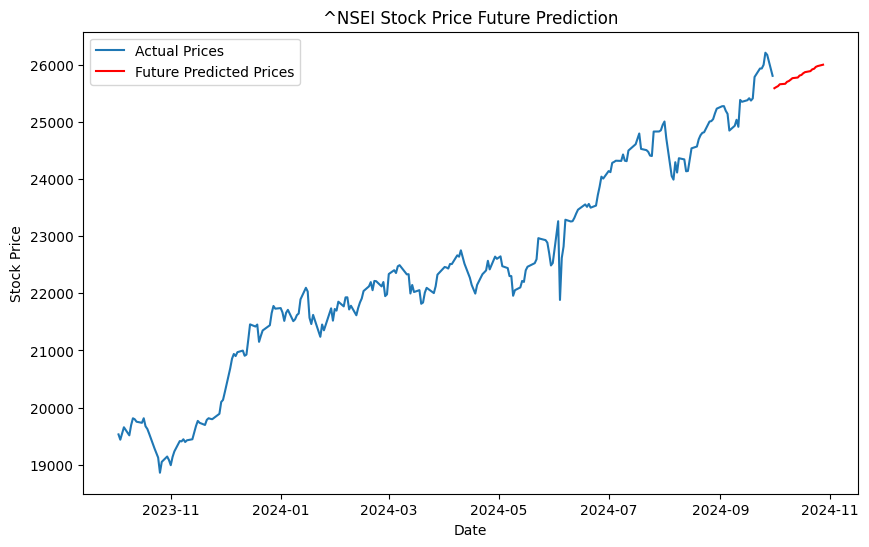

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data, label='Actual Prices')
future_dates = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='B')[1:]
plt.plot(future_dates, future_predictions, label='Future Predicted Prices', color='red')
plt.title(f'{ticker} Stock Price Future Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

forecasted_values = np.array(future_predictions) # forecasted values from ARIMA Model
forecasted_values

array([25594.19007961, 25613.96378177, 25630.52273505, 25663.54637855,
       25671.4660216 , 25706.35822729, 25719.48196573, 25743.60914248,
       25770.09462292, 25781.79340129, 25816.53512205, 25826.18189605,
       25856.36886241, 25875.80740132, 25893.62911412, 25924.69802562,
       25934.62090437, 25967.86862747, 25981.7413712 , 26006.07194405])

In [93]:
raw_actual = yf.download(ticker, start='2024-10-01', end='2024-10-30')


[*********************100%***********************]  1 of 1 completed


In [94]:
raw_actual.dropna(inplace=True)
actual_values = np.array(raw_actual['Close'])

actual_values

array([[25796.90039062],
       [25250.09960938],
       [25014.59960938],
       [24795.75      ],
       [25013.15039062],
       [24981.94921875],
       [24998.44921875],
       [24964.25      ],
       [25127.94921875],
       [25057.34960938],
       [24971.30078125],
       [24749.84960938],
       [24854.05078125],
       [24781.09960938],
       [24472.09960938],
       [24435.5       ],
       [24399.40039062],
       [24180.80078125],
       [24339.15039062],
       [24466.84960938]])

In [95]:
mape = np.mean(np.abs((actual_values - forecasted_values) / actual_values)) * 100

In [96]:
mae = mean_absolute_error(actual_values, forecasted_values)

In [97]:
rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))

In [98]:
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Percentage Error (MAPE): 3.93%
Mean Absolute Error (MAE): 986.67
Root Mean Squared Error (RMSE): 1078.44


In [100]:
df_arima = pd.DataFrame(forecasted_values)
df_arima.dropna(inplace=True)
df_arima.to_csv('/Users/divyanshu/PycharmProjects/MiniProject/arima.csv')